In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import sys
sys.path.insert(0, '/home/olle/PycharmProjects/LODE/feature_segmentation/utils')

import plotting
plt.style.use('seaborn')

data_file = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_properties_naive.csv"
data_pd = pd.read_csv(data_file)

#### add patient id and lateraliy

data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

In [43]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [2]:
data_pd.head()

,Unnamed: 0,sequence,study_date_1,total_fluid_1,time_range_1,time_range_before_1,time_range_after_1,insertion_type_1,cur_va_rounded_1,next_va_1,...,S1_13_24,S2_13_24,N1_13_24,N2_13_24,C0_13_24,I1_13_24,I2_13_24,Naive,patient_id,laterality
0,0,18_R,2017-10-24,0.001141,NaN,NaN,NaN,NaN,0.40,0.494850,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,18,R
1,1,502_L,2017-07-04,0.002359,NaN,NaN,NaN,NaN,0.30,0.200659,...,0.001228,0.0,0.000000,0.000000,0.001185,0.006170,0.000779,1.0,502,L
2,2,502_R,2016-04-04,0.000534,NaN,NaN,NaN,NaN,0.10,0.494850,...,0.000061,0.0,0.000000,0.000000,0.000340,0.000000,0.000000,NaN,502,R
3,3,709_L,2016-08-08,0.270185,NaN,NaN,NaN,NaN,0.30,0.397940,...,0.062774,0.0,0.146249,0.008603,0.174822,0.000000,0.000000,1.0,709,L
4,4,709_R,2015-11-25,0.716147,NaN,NaN,NaN,NaN,0.89,1.000000,...,0.000000,0.0,0.000000,0.000521,0.000000,0.112738,0.279206,NaN,709,R


In [3]:
data_pd = data_pd.dropna(subset=["Naive"])

print("Number of naive time series ", data_pd.shape)

Number of naive time series  (405, 500)


## add delta feature columns

In [4]:
time_points = [6, 12]

features = ["intra_retinal_fluid", 
            "sub_retinal_fluid", 
            "choroid", 
            "drusen", 
            "rpe", 
            "fibrovascular_ped",
            "epiretinal_membrane",
            "srhm", 
            "fibrosis"]

for tp in time_points:
    for feature in features:
        data_pd[f"{feature}_delta_{tp}"] = data_pd[f"{feature}_{tp}"] - data_pd[f"{feature}_{1}"]

#### How many sequence are treated?

In [5]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 405


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

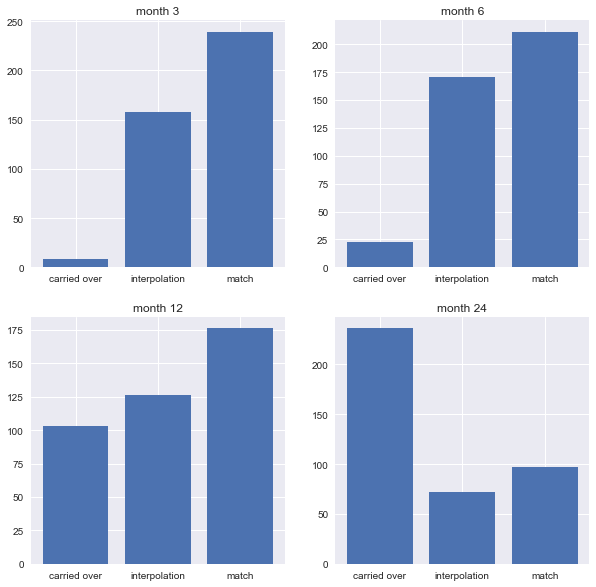

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

### carried over time distribution

Text(0.5, 1.0, 'Time from carry over 6 months')

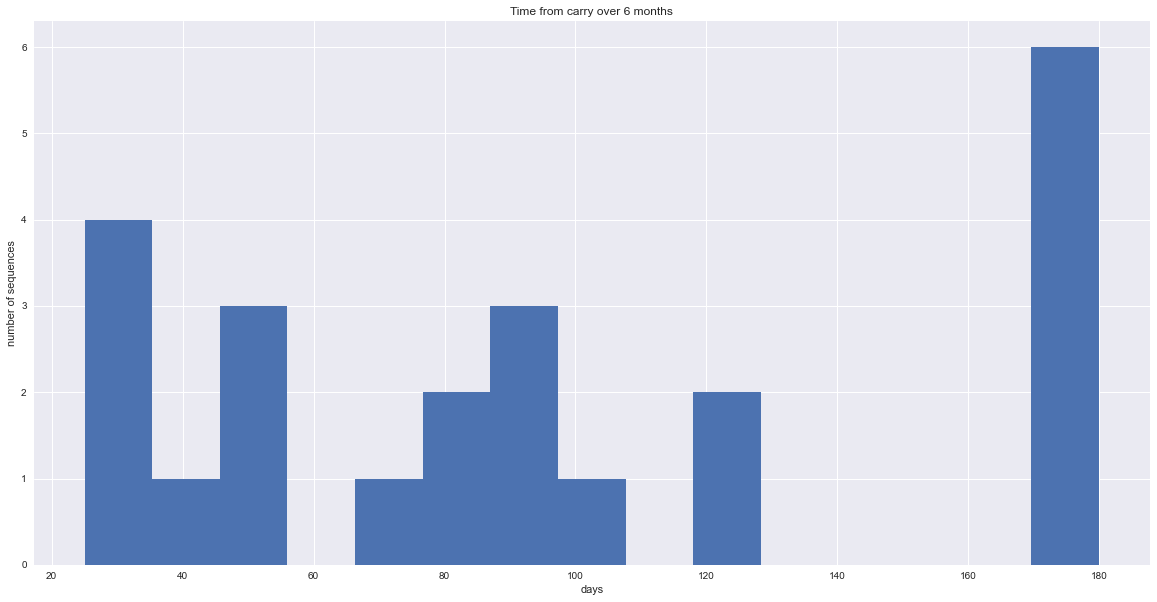

In [7]:
plt.figure(figsize=(20,10))
month_6_carry_over = data_pd.loc[data_pd.insertion_type_6 == "carry_over"]
plt.hist(month_6_carry_over.time_range_6, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 6 months")

Text(0.5, 1.0, 'Time from carry over 12 months')

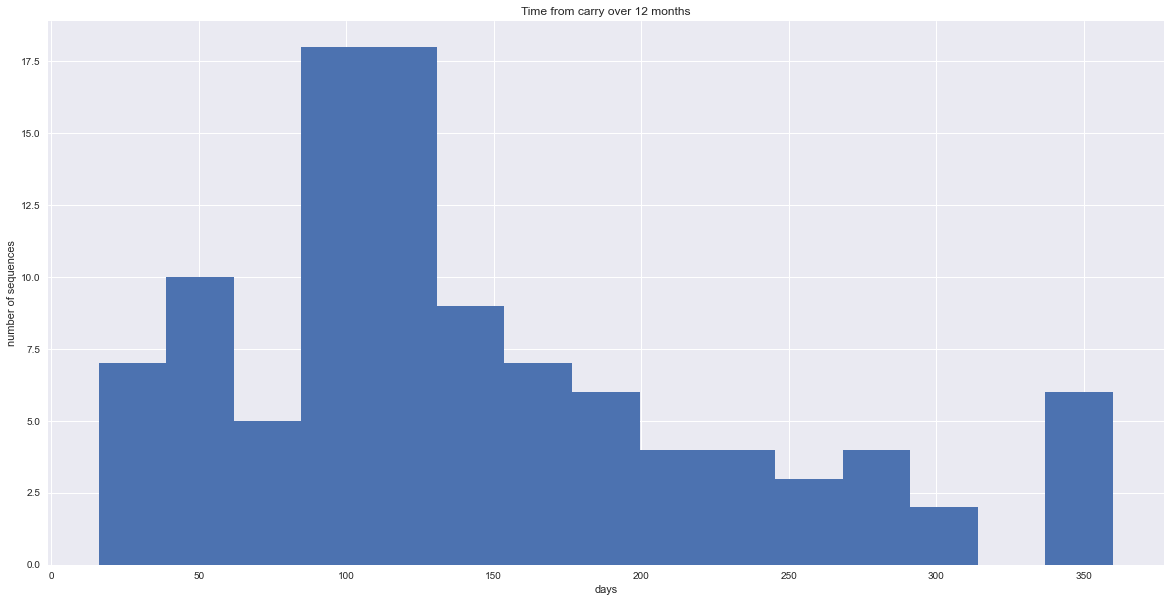

In [8]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 12 months")


### interpolation over time distribution

Text(0.5, 1.0, 'Time from interpolation 6 months')

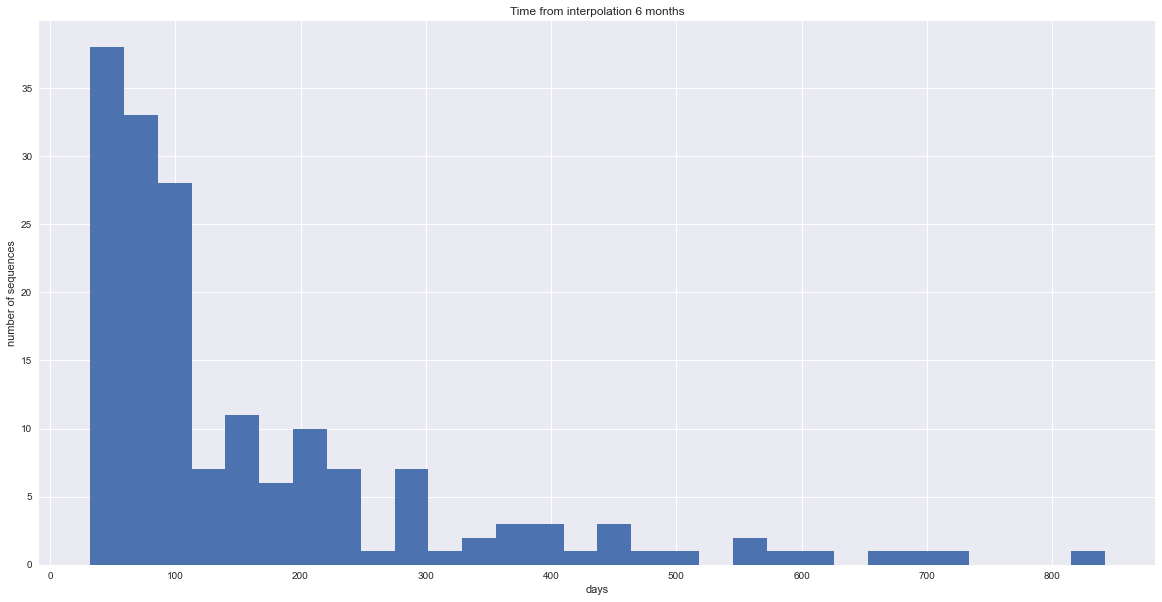

In [9]:
plt.figure(figsize=(20,10))
month_6_interpolation = data_pd.loc[data_pd.insertion_type_6 == "interpolation"]
plt.hist(month_6_interpolation.time_range_6, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 6 months")

Text(0.5, 1.0, 'Time from interpolation 12 months')

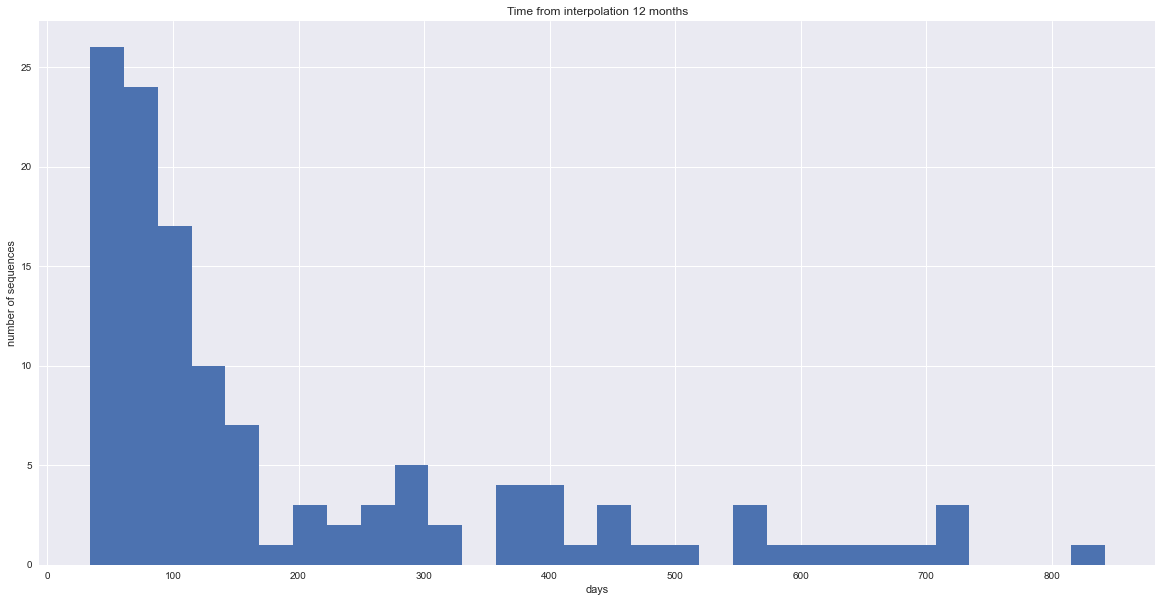

In [10]:
plt.figure(figsize=(20,10))
month_12_interpolation = data_pd.loc[data_pd.insertion_type_12 == "interpolation"]
plt.hist(month_12_interpolation.time_range_12, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 12 months")

#### Time until dry

In [11]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))

Number of sequences starting as dry:  6
Number of sequences dry after 3 months:  8
Number of sequences dry after 6 months:  7
Number of sequences dry after 12 months:  7
Number of sequences dry after 24 months:  14


#### Filter data based on time series eclusion criterias

In [12]:
##### carry over above 2 months

In [13]:
columns = ["time_range_6", "time_range_before_6", "time_range_after_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12",
          "insertion_type_6", "insertion_type_12"]

filter_base = data_pd[columns]

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 


interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match" 

# interpolation time filters
interp_time_before_6 = filter_base.time_range_before_6 < 60
interp_time_after_6 = filter_base.time_range_after_6 < 60

interp_time_before_12 = filter_base.time_range_before_12 < 60
interp_time_after_12 = filter_base.time_range_after_12 < 60

# carry over time filters
carry_over_time_after_6 = filter_base.time_range_6 < 60
carry_over_time_after_12 = filter_base.time_range_12 < 60

In [14]:
# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))

Number of filtered sequences for 6 months are: 295


In [15]:
# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 12 months are: 242


## Filter data pd for having either a 6 or a 12 month follow up

In [16]:
data_final_pd = data_pd.loc[filter_12 | filter_6]

## Create Adata objects

In [17]:
feature_columns = ["total_fluid",
"next_va",
"cumsum_injections",
'intra_retinal_fluid',
'sub_retinal_fluid',
'srhm',
'fibrovascular_ped',
'choroid',
'drusen',
'rpe',
'epiretinal_membrane',
'fibrosis']

In [18]:
regions = ["T1", "T2", "S1", "S2", "N1", "N2", "I1", "I2", "C0"]
features = [1, 3, 4, 5, 6, 7, 8, 10, 13]
time_points = [1]

var_names = []
for region in regions:
    for feature in features:
        var_names.append(f"{region}_{feature}_{1}")

## Base line Adata

#### Extract baseline columns for data data frame

In [19]:
columns = ['patient_id', 'laterality', 'cur_va_rounded_1'] + var_names
data_baseline_pd = data_final_pd[columns]

data_baseline_pd["sequence"] = data_baseline_pd["patient_id"] + "_" + data_baseline_pd["laterality"]

/home/olle/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Create baseline adata

In [20]:
data_baseline_pd = data_baseline_pd.dropna(subset=["sequence"])

X = np.array(data_baseline_pd[np.array(var_names)])

obs_id = data_baseline_pd["sequence"]

adata_baseline = sc.AnnData(X=X)
adata_baseline.obs["obs_id"] = obs_id.values.tolist()
adata_baseline.obs["baseline_va"] = data_baseline_pd.cur_va_rounded_1.values.tolist()

adata_baseline.var_names = var_names

## Factors associated with baseline visual acuity

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [25]:
regression_pd = pd.DataFrame(adata_baseline.X, columns=adata_baseline.var_names)
regression_pd["va"] = adata_baseline.obs["baseline_va"].values.tolist()

model_lin = sm.OLS.from_formula(f"va ~ {' + '.join(var_names)}", data=regression_pd)
result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [29]:
adata_baseline.var["linear_coef"] = reg_table["coef"]
adata_baseline.var['P>|t|'] = reg_table['P>|t|']

In [60]:
pd.DataFrame(adata_baseline.var.index.str.split("_")

Index([ ['T1', '1', '1'],  ['T1', '3', '1'],  ['T1', '4', '1'],
        ['T1', '5', '1'],  ['T1', '6', '1'],  ['T1', '7', '1'],
        ['T1', '8', '1'], ['T1', '10', '1'], ['T1', '13', '1'],
        ['T2', '1', '1'],  ['T2', '3', '1'],  ['T2', '4', '1'],
        ['T2', '5', '1'],  ['T2', '6', '1'],  ['T2', '7', '1'],
        ['T2', '8', '1'], ['T2', '10', '1'], ['T2', '13', '1'],
        ['S1', '1', '1'],  ['S1', '3', '1'],  ['S1', '4', '1'],
        ['S1', '5', '1'],  ['S1', '6', '1'],  ['S1', '7', '1'],
        ['S1', '8', '1'], ['S1', '10', '1'], ['S1', '13', '1'],
        ['S2', '1', '1'],  ['S2', '3', '1'],  ['S2', '4', '1'],
        ['S2', '5', '1'],  ['S2', '6', '1'],  ['S2', '7', '1'],
        ['S2', '8', '1'], ['S2', '10', '1'], ['S2', '13', '1'],
        ['N1', '1', '1'],  ['N1', '3', '1'],  ['N1', '4', '1'],
        ['N1', '5', '1'],  ['N1', '6', '1'],  ['N1', '7', '1'],
        ['N1', '8', '1'], ['N1', '10', '1'], ['N1', '13', '1'],
        ['N2', '1', '1'],  ['N2', '3', '

In [ ]:
regions = ["T1", "T2", "S1", "S2", "N1", "N2", "I1", "I2", "C0"]
features = [1, 3, 4, 5, 6, 7, 8, 10, 13]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

In [ ]:
data_pd = data_pd.dropna(subset=["sequence", "study_date_1"])

X = np.array(data_pd[np.array(var_names)])

obs_id = data_pd["sequence"] + "_" + data_pd["study_date_1"]

va_improved_6 = data_pd.cur_va_rounded_6 - data_pd.cur_va_rounded_1 < 0
va_improved_12 = data_pd.cur_va_rounded_12 - data_pd.cur_va_rounded_1 < 0

adata_baseline = sc.AnnData(X=X)
adata_baseline.obs["obs_id"] = obs_id.values.tolist()
adata_baseline.obs["obs_va_6_improved"] = va_improved_6.astype(int).values.tolist()
adata_baseline.obs["obs_va_12_improved"] = va_improved_12.astype(int).values.tolist()

adata_baseline.obs["va_delta_6"] = pd.DataFrame(data_pd.cur_va_rounded_6 - data_pd.cur_va_rounded_1)[0].values
adata_baseline.obs["va_delta_12"] = pd.DataFrame(data_pd.cur_va_rounded_12 - data_pd.cur_va_rounded_1)[0].values

data_pd["cumsum_injections_1"] = data_pd.cumsum_injections_1.fillna(0)
data_pd["cumsum_injections_6"] = data_pd.cumsum_injections_6.fillna(0)
data_pd["cumsum_injections_12"] = data_pd.cumsum_injections_12.fillna(0)

adata_baseline.obs["cumsum_injections_1"] = data_pd.cumsum_injections_1.values
adata_baseline.obs["cumsum_injections_6"] = data_pd.cumsum_injections_6.values
adata_baseline.obs["cumsum_injections_12"] = data_pd.cumsum_injections_12.values

adata_baseline.obs["obs_va_1"] = data_pd.cur_va_rounded_1.values.tolist()
adata_baseline.obs["obs_va_6"] = data_pd.cur_va_rounded_6.values.tolist()
adata_baseline.obs["obs_va_12"] = data_pd.cur_va_rounded_12.values.tolist()

for region in regions:
    for feature in features:
        for time_point in [1, 6, 12]:
            var_ = f"{region}_{feature}_{time_point}"
            adata_baseline.obs[var_] = data_pd[var_].values.tolist()

for feature in feature_columns:
    for time_point in [1, 6, 12]:
            var_ = f"{feature}_{time_point}"
            adata_baseline.obs[var_] = data_pd[var_].values.tolist()
    
adata_baseline.obs["naive"] = data_pd.Naive.values.tolist()
adata_baseline.var["var_name"] = var_names

### Basic statistics

In [ ]:
print(f"Base line mean BCVA {np.mean(adata_baseline.obs.obs_va_1)} +- {np.std(adata_baseline.obs.obs_va_1)}")
print(f"6 month mean BCVA {np.mean(adata_baseline.obs.obs_va_6)} +- {np.std(adata_baseline.obs.obs_va_6)}")
print(f"12 month mean BCVA {np.mean(adata_baseline.obs.obs_va_12)} +- {np.std(adata_baseline.obs.obs_va_12)}")

In [ ]:
print(f"6 month mean BCVA change {np.mean(adata_baseline.obs.va_delta_6)} +- {np.std(adata_baseline.obs.va_delta_6)}")
print(f"12 month mean BCVA change {np.mean(adata_baseline.obs.va_delta_12)} +- {np.std(adata_baseline.obs.va_delta_12)}")

In [ ]:
print(f"6 month average # injections {np.mean(adata_baseline.obs.cumsum_injections_6)} +- {np.std(adata_baseline.obs.cumsum_injections_6)}")
print(f"12 month average # injections {np.mean(adata_baseline.obs.cumsum_injections_12)} +- {np.std(adata_baseline.obs.cumsum_injections_12)}")

In [ ]:
for feature in feature_columns:
    for time_point in [1, 6, 12]:
            var_ = f"{feature}_{time_point}"
            stat_str = f"mean {np.round(np.mean(adata_baseline.obs[var_]), 2)} +- {np.round(np.std(adata_baseline.obs[var_]), 2)}"
            print(f"{time_point} month recording of {var_}: {stat_str}")

## Regression analysis

In [ ]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

In [ ]:
## plot distributions

In [ ]:
sc.pl.violin(adata_baseline, var_names, log=True)

In [ ]:
## normalize data

In [ ]:
adata_baseline.var

In [ ]:
sc.pp.normalize_total(adata_baseline, target_sum=1, inplace=True)
adata_baseline.obs["T1_3_1"]

In [ ]:
## PCA analysis

In [ ]:
sc.tl.pca(adata_baseline, n_comps=10, svd_solver='arpack')
sc.pl.pca(adata_baseline, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved', "va_delta_6", "va_delta_12"],
          vmax='p85', vmin='p15')


In [ ]:
## unsupervised learning on data

In [ ]:
sc.pp.neighbors(adata_baseline, n_neighbors=20, n_pcs=10)
sc.tl.umap(adata_baseline)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_baseline, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved',
                         "va_delta_6", "va_delta_12"], vmax='p85', vmin='p15')

In [ ]:
adata_va_delta_filtered = adata[np.abs(adata_baseline.obs.va_delta_6) > 0.15]

In [ ]:
sc.pp.neighbors(adata_va_delta_filtered, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_va_delta_filtered)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_va_delta_filtered, color=['intra_retinal_fluid_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved',
                         "va_delta_6", "va_delta_12"])

### 6 month Adata

In [ ]:
X_dict = {}
for region in regions:
    for feature in features:
        var_ = f"{region}_{feature}_{16}_delta"
        var_1 = f"{region}_{feature}_{1}"
        var_6 = f"{region}_{feature}_{6}"

        X_dict[var_] = data_pd[var_1].values - data_pd[var_6].values

In [ ]:
delta_six_month_pd = pd.DataFrame(X_dict)

var_names = delta_six_month_pd.columns.tolist()

X = np.array(delta_six_month_pd[np.array(var_names)])

adata_six_month = sc.AnnData(X=X)
adata_six_month.var_names = var_names
adata_six_month.obs = adata_baseline.obs

In [ ]:
sc.pl.violin(adata_six_month, var_names, log=True)

In [ ]:
sc.pp.normalize_total(adata_six_month, target_sum=1, inplace=True)

In [ ]:
sc.tl.pca(adata_six_month, n_comps=10, svd_solver='arpack')
sc.pl.pca(adata_six_month, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved', "va_delta_6", "va_delta_12"])


In [ ]:
sc.pp.neighbors(adata_six_month, n_neighbors=20, n_pcs=10)
sc.tl.umap(adata_six_month)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_six_month, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved',
                         "va_delta_6", "va_delta_12"])

#### Define VA fate groups

In [ ]:
#### Worsened v. Imporoved

In [ ]:
data_6 = data_pd.loc[filter_6]
data_12 = data_pd.loc[filter_12]

In [ ]:
print("Number of patients in 6 month cohort:", data_6.patient_id.drop_duplicates().shape[0])
print("Number of patients in 12 month cohort:", data_12.patient_id.drop_duplicates().shape[0])

In [ ]:
va_delta_6 = data_6.cur_va_rounded_6 - data_6.cur_va_rounded_1 
va_delta_12 = data_12.cur_va_rounded_12 - data_12.cur_va_rounded_1 

data_6["six_month_recovery"] = va_delta_6 <= 0
data_12["twelwe_month_recovery"] = va_delta_12 <= 0

print("six month recovery: ", sum(data_6["six_month_recovery"]))
print("twelwe month recovery: ", sum(data_12["twelwe_month_recovery"]))

In [ ]:
#### Considerably worsened v. Imporoved

In [ ]:
va_delta_6 = data_6.cur_va_rounded_6 - data_6.cur_va_rounded_1 
va_delta_12 = data_12.cur_va_rounded_12 - data_12.cur_va_rounded_1 

data_6["six_consid_month_recovery"]= "no change"
data_6["six_consid_month_recovery"][va_delta_6 <= -0.15] = "improved"
data_6["six_consid_month_recovery"][va_delta_6 >= 0.15] = "worsened"

data_12["twelwe_consid_month_recovery"]= "no change"
data_12["twelwe_consid_month_recovery"][va_delta_12 <= -0.15] = "improved"
data_12["twelwe_consid_month_recovery"][va_delta_12 >= 0.15] = "worsened"

print(np.unique(data_6["six_consid_month_recovery"], return_counts=True))
print(np.unique(data_12["twelwe_consid_month_recovery"], return_counts=True))

In [ ]:
### Improved from VI to NVI

In [ ]:
vi6_1 = data_6.cur_va_rounded_1 >= 0.4 
nvi_6 = data_6.cur_va_rounded_6 < 0.4

vi12_1 = data_12.cur_va_rounded_1 >= 0.4 
nvi_12 = data_12.cur_va_rounded_12 < 0.4 

data_6["six_month_vi_recovery"] = np.logical_and(vi6_1.values, nvi_6.values)
data_12["twelwe_month_vi_recovery"] = np.logical_and(vi12_1.values, nvi_12.values)

print("six month vi recovery: ", sum(data_6["six_month_vi_recovery"]))
print("twelwe month vi recovery: ", sum(data_12["twelwe_month_vi_recovery"]))

In [ ]:
### Improved from LB to NLB

In [ ]:
lb6_1 = data_6.cur_va_rounded_1 >= 1.0
nlb_6 = data_6.cur_va_rounded_6 < 1.0 

lb12_1 = data_12.cur_va_rounded_1 >= 1.0
nlb_12 = data_12.cur_va_rounded_12 < 1.0 

data_6["six_month_lb_recoverment"] = np.logical_and(lb6_1.values, nlb_6.values)
data_12["twelwe_month_lb_recoverment"] = np.logical_and(lb12_1.values, nlb_12.values)

print("six month lb recoverment: ", sum(data_6["six_month_lb_recoverment"]))
print("twelwe month lb recoverment: ", sum(data_12["twelwe_month_lb_recoverment"]))


## linear mixed effect modeling

In [ ]:
data_6.columns.values

data_6.six_month_recovery



### VA outcome distribution plotting

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
sns.set_theme(style="whitegrid")

In [ ]:
#### six month outcome
value_columns = ["intra_retinal_fluid_6", "sub_retinal_fluid_6", "fibrosis_6", 
          "fibrovascular_ped_6", "rpe_6", "epiretinal_membrane_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_6_scaled", 
                        "sub_retinal_fluid_6_scaled", "fibrosis_6_scaled", 
                        "fibrovascular_ped_6_scaled", "rpe_6_scaled", 
                        "epiretinal_membrane_6_scaled"]


data_6_plotting = pd.melt(data_6, id_vars=["six_month_recovery"], value_vars=value_columns_scaled)

data_6_plotting = data_6_plotting.loc[data_6_plotting.value.values != 1.000]

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="six_month_recovery",
                 data=data_6_plotting, linewidth=2.5, showfliers=False)

plt.xlabel("Feature")
plt.ylabel("Normalized feature distribution")

In [ ]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_12", "sub_retinal_fluid_12", "fibrosis_12", 
          "fibrovascular_ped_12", "rpe_12", "epiretinal_membrane_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_12_scaled", 
                        "sub_retinal_fluid_12_scaled", "fibrosis_12_scaled", 
                        "fibrovascular_ped_12_scaled", "rpe_12_scaled", 
                        "epiretinal_membrane_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_month_recovery"], value_vars=value_columns_scaled)

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_month_recovery",
                 data=data_12_plotting, linewidth=2.5, showfliers=False)

In [ ]:
data_12.columns.values

#### Plotting delta values

In [ ]:
#### 6 month outcome
value_columns = ["intra_retinal_fluid_delta_6", "sub_retinal_fluid_delta_6", 
          "fibrovascular_ped_delta_6", "rpe_delta_6", "epiretinal_membrane_delta_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_6_scaled", "sub_retinal_fluid_delta_6_scaled", 
                        "fibrovascular_ped_delta_6_scaled", 
                        "rpe_delta_6_scaled", "epiretinal_membrane_delta_6_scaled"]

data_6_plotting = pd.melt(data_6, id_vars=["six_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="six_month_recovery",
                 data=data_6_plotting, linewidth=2.5, showfliers=False)

ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])


plt.title("6 month progression")
plt.xlabel("feature")
plt.ylabel("delta (mm3)")


In [ ]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_delta_12", "sub_retinal_fluid_delta_12", "fibrosis_delta_12", 
          "fibrovascular_ped_delta_12", "rpe_delta_12", "epiretinal_membrane_delta_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_12_scaled", "sub_retinal_fluid_delta_12_scaled", 
                        "fibrosis_delta_12_scaled", "fibrovascular_ped_delta_12_scaled", 
                        "rpe_delta_12_scaled", "epiretinal_membrane_delta_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_month_recovery",
                 data=data_12_plotting, linewidth=2.5, showfliers=False)


ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrosis", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])

plt.title("12 month progression")
plt.xlabel("feature")
plt.ylabel("delta (mm3)")

### Cases with considerable recovery or worsening

In [ ]:
print(np.unique(data_6["six_consid_month_recovery"], return_counts=True))
print(np.unique(data_12["twelwe_consid_month_recovery"], return_counts=True))

In [ ]:
#### 6 month outcome
value_columns = ["intra_retinal_fluid_delta_6", "sub_retinal_fluid_delta_6", "fibrosis_delta_6", 
          "fibrovascular_ped_delta_6", "rpe_delta_6", "epiretinal_membrane_delta_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_6_scaled", "sub_retinal_fluid_delta_6_scaled", 
                        "fibrosis_delta_6_scaled", "fibrovascular_ped_delta_6_scaled", 
                        "rpe_delta_6_scaled", "epiretinal_membrane_delta_6_scaled"]

data_6_plotting = pd.melt(data_6, id_vars=["six_consid_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="six_consid_month_recovery",
                 data=data_6_plotting, linewidth=2.5, showfliers=False)

ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrosis", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])


plt.title("6 month progression")

plt.xlabel("feature")
plt.ylabel("delta (mm3)")


In [ ]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_delta_12", "sub_retinal_fluid_delta_12", "fibrosis_delta_12", 
          "fibrovascular_ped_delta_12", "rpe_delta_12", "epiretinal_membrane_delta_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_12_scaled", "sub_retinal_fluid_delta_12_scaled", 
                        "fibrosis_delta_12_scaled", "fibrovascular_ped_delta_12_scaled", 
                        "rpe_delta_12_scaled", "epiretinal_membrane_delta_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_consid_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_consid_month_recovery",
                 data=data_12_plotting, linewidth=2.5, showfliers=False)


ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrosis", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])

plt.title("12 month progression")
plt.xlabel("feature")
plt.ylabel("delta (mm3)")